In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'STA6923/coronahack-chest-x-ray'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


# Load Packages and Setup

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LayerNormalization
import cv2
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image

import matplotlib.pyplot as plt

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

%matplotlib inline

DATASET_DIR = 'drive/MyDrive/STA6923/coronahack-chest-x-ray/dataset'
METADATA_FILE = 'drive/MyDrive/STA6923/coronahack-chest-x-ray/dataset/Chest_xray_Corona_Metadata.csv'
TRAIN_DIR = 'drive/MyDrive/STA6923/coronahack-chest-x-ray/dataset/train'
TEST_DIR = 'drive/MyDrive/STA6923/coronahack-chest-x-ray/dataset/test'

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6702434608426121283
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3330473426317741767
physical_device_desc: "device: XLA_CPU device"
]


# Summary Stats

In [ ]:
metadata = pd.read_csv(METADATA_FILE)

In [ ]:
metadata.head(2)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN


In [ ]:
metadata[['X_ray_image_name', 'Dataset_type', 'Label_2_Virus_category', 'Label_1_Virus_category', 'Label']].groupby(by=['Dataset_type', 'Label_2_Virus_category', 'Label_1_Virus_category', 'Label'], dropna=False).count()

X_ray_image_name
Dataset_type Label_2_Virus_category Label_1_Virus_category Label                     
TEST         NaN                    Virus                  Pnemonia               148
                                    bacteria               Pnemonia               242
                                    NaN                    Normal                 234
TRAIN        ARDS                   Stress-Smoking         Pnemonia                 2
             COVID-19               Virus                  Pnemonia                58
             SARS                   Virus                  Pnemonia                 4
             Streptococcus          bacteria               Pnemonia                 5
             NaN                    Virus                  Pnemonia              1345
                                    bacteria               Pnemonia              2530
                                    NaN                    Normal                1342

## Image Examples and Histograms

Normal


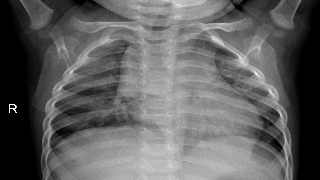



Pnemonia


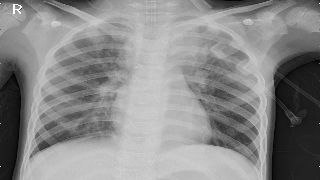

In [ ]:
EXAMPLE_NORMAL_IMAGE = 'IM-0128-0001.jpeg'
EXAMPLE_PNEMONIA_IMAGE = 'person101_virus_187.jpeg'

normal_example_image = io.imread(os.path.join(TRAIN_DIR, EXAMPLE_NORMAL_IMAGE)) 
pnemonia_example_image = io.imread(os.path.join(TRAIN_DIR, EXAMPLE_PNEMONIA_IMAGE))
print("Normal")
cv2_imshow(cv2.resize(normal_example_image, (320, 180)))
print("\n")
print("Pnemonia")
cv2_imshow(cv2.resize(pnemonia_example_image, (320, 180)))

Normal


(<matplotlib.axes._subplots.AxesSubplot at 0x7fb69cb6cf98>,
 Text(0.5, 1.0, 'Contour'))

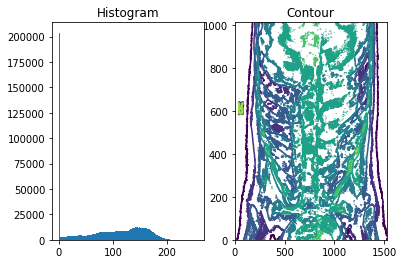

In [ ]:
print('Normal')
plt.subplot(121),plt.hist(normal_example_image.ravel(),bins = 256, range = [0,256]),plt.title('Histogram') 
plt.subplot(122),plt.contour(normal_example_image),plt.title('Contour')

Pnemonia


(<matplotlib.axes._subplots.AxesSubplot at 0x7fb69db57a58>,
 Text(0.5, 1.0, 'Contour'))

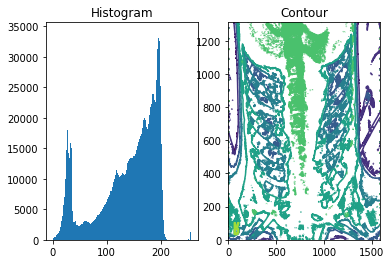

In [ ]:
print('Pnemonia')
plt.subplot(121),plt.hist(pnemonia_example_image.ravel(),bins = 256, range = [0,256]),plt.title('Histogram') 
plt.subplot(122),plt.contour(pnemonia_example_image),plt.title('Contour')

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb69b724780>,
 Text(0.5, 1.0, 'Pnemonia'))

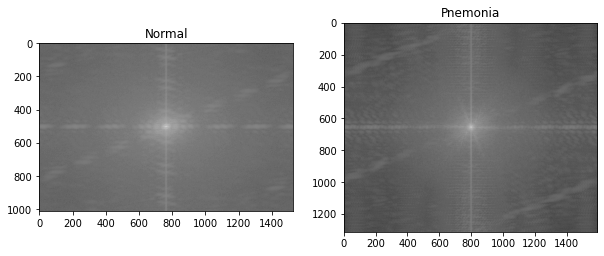

In [ ]:
def plot_fft2(image):
  # image = cv2.blur(image, (10, 10))
  f = np.fft.fft2(image)
  # Shift zero-frequency component to center of spectrum
  f_shift = np.fft.fftshift(f)
  return 300 * np.log(np.abs(f_shift))

plt.rcParams["figure.figsize"] = (10,10)

plt.subplot(121),plt.imshow(plot_fft2(normal_example_image), cmap='gray'),plt.title('Normal')
plt.subplot(122),plt.imshow(plot_fft2(pnemonia_example_image), cmap='gray'),plt.title('Pnemonia')

# Data Preprocessing

In [ ]:
metadata.head(2)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN


In [ ]:
num_images = metadata.shape[0]

X_train = []
y_train = []
X_test = []
y_test = []

np.random.seed(101)

num_classes = 2
# subsample 45% of training data
train_sample_rate = 1.0
# subsample 40% of test data
test_sample_rate = 1.0
# image size
image_target_size = (300, 300)

for i in range(num_images):
  if (i % 1000 == 0):
    print("Processed {} images so far".format(i))
  if metadata.loc[i, 'Dataset_type'] == 'TRAIN':
    # perform stratified subsampling
    if (metadata.loc[i, 'Label'] == 'Pnemonia'):
      if (np.random.rand() > train_sample_rate):
        continue
    else:
      if (np.random.rand() > train_sample_rate):
        continue
    
    X_train.append(tf.keras.preprocessing.image.img_to_array(
        tf.keras.preprocessing.image.load_img(
            os.path.join(TRAIN_DIR, metadata.loc[i, 'X_ray_image_name']),
            grayscale=True,
            target_size=image_target_size,
            interpolation='nearest'
            )))
    y_train.append(np.int32(metadata.loc[i, 'Label'] == 'Pnemonia'))
  elif metadata.loc[i, 'Dataset_type'] == 'TEST':
    # perform stratified subsampling
    if (metadata.loc[i, 'Label'] == 'Pnemonia'):
      if (np.random.rand() > test_sample_rate):
        continue
    else:
      if (np.random.rand() > test_sample_rate):
        continue
    
    X_test.append(
        tf.keras.preprocessing.image.img_to_array(
            tf.keras.preprocessing.image.load_img(
                os.path.join(TEST_DIR, metadata.loc[i, 'X_ray_image_name']),
                grayscale=True,
                target_size=image_target_size,
                interpolation='nearest'
                )))
    y_test.append(np.int32(metadata.loc[i, 'Label'] == 'Pnemonia'))

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Standardize - note that X_test is standardized using the summary stats from the training set
print("Normalizing pixels...")
mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
X_train = (X_train - mean_pixel) / std_pixel
X_test = (X_test - mean_pixel) / std_pixel
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

Processed 0 images so far


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Processed 1000 images so far
Processed 2000 images so far
Processed 3000 images so far
Processed 4000 images so far
Processed 5000 images so far
Normalizing pixels...


In [ ]:
print("X_train.shape: {}".format(X_train.shape))
print("X_test.shape: {}".format(X_test.shape))
print("y_train.shape: {} and number of positive: {}".format(y_train.shape, y_train.sum(axis=0)))
print("y_test.shape: {} and number of positive: {}".format(y_test.shape, y_test.sum(axis=0)))

X_train.shape: (5286, 300, 300, 1)
X_test.shape: (624, 300, 300, 1)
y_train.shape: (5286, 2) and number of positive: [1342. 3944.]
y_test.shape: (624, 2) and number of positive: [234. 390.]


## A basline NN

In [ ]:
def create_baseline_nn(num_classes, learning_rate):
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.Precision(class_id=1),
                       tf.keras.metrics.Recall(class_id=1),
                       tf.keras.metrics.AUC()])
  return model

In [ ]:
# !rm -rf drive/MyDrive/STA6923/coronahack-chest-x-ray/baseline_nn
# !mkdir drive/MyDrive/STA6923/coronahack-chest-x-ray/baseline_nn

In [ ]:
batch_size = 64
num_epochs = 30
learning_rate = 1e-3

#baseline_nn_checkpoint_path = "drive/MyDrive/STA6923/coronahack-chest-x-ray/baseline_nn/cp-{epoch:04d}.ckpt"
baseline_nn_checkpoint_path = "drive/MyDrive/STA6923/coronahack-chest-x-ray/baseline_nn/model.{epoch:02d}-{val_loss:.2f}.hdf5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=baseline_nn_checkpoint_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=False,
    save_weights_only=False)

# Create a new model instance
baseline_nn_model = create_baseline_nn(2, learning_rate)

start_time = time.time()
baseline_nn_model.fit(X_train, y_train,
                      batch_size=batch_size,
                      epochs=num_epochs,
                      callbacks=[cp_callback],
                      shuffle=True,
                      validation_split=0.5)
elapsed_time = time.time() - start_time
print("Elapsed time: {} seconds".format(elapsed_time))

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 6.0922 - categorical_accuracy: 0.8313 - precision_2: 0.8333 - recall_2: 0.8218 - auc_2: 0.8437
Epoch 00001: saving model to drive/MyDrive/STA6923/coronahack-chest-x-ray/baseline_nn/model.01-1.09.hdf5
42/42 [==============================] - 2s 38ms/step - loss: 6.0922 - categorical_accuracy: 0.8313 - precision_2: 0.8333 - recall_2: 0.8218 - auc_2: 0.8437 - val_loss: 1.0897 - val_categorical_accuracy: 0.9501 - val_precision_2: 1.0000 - val_recall_2: 0.9500 - val_auc_2: 0.9592
Epoch 2/30
40/42 [===========================>..] - ETA: 0s - loss: 1.2095 - categorical_accuracy: 0.9348 - precision_2: 0.9331 - recall_2: 0.9353 - auc_2: 0.9475
Epoch 00002: saving model to drive/MyDrive/STA6923/coronahack-chest-x-ray/baseline_nn/model.02-1.10.hdf5
42/42 [==============================] - 1s 29ms/step - loss: 1.2202 - categorical_accuracy: 0.9342 - precision_2: 0.9332 - recall_2: 0.9332 - auc_2: 0.9464 - val_loss: 1.0985 - val_ca

In [ ]:
baseline_nn_model = tf.keras.models.load_model('drive/MyDrive/STA6923/coronahack-chest-x-ray/baseline_nn/model.28-0.66.hdf5')

baseline_nn_model.summary()
score = baseline_nn_model.evaluate(X_test, y_test)
print('loss: {} - categorical_accuracy: {} - precision_15: {} - recall_15: {} - auc_14: {}'.format(score[0], score[1], score[2], score[3], score[4]))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 90000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 180002    
Total params: 180,002
Trainable params: 180,002
Non-trainable params: 0
_________________________________________________________________
20/20 [==============================] - 0s 10ms/step - loss: 12.9301 - categorical_accuracy: 0.7147 - precision_2: 0.6906 - recall_2: 0.9846 - auc_2: 0.7240
loss: 12.930057525634766 - categorical_accuracy: 0.7147436141967773 - precision_15: 0.6906474828720093 - recall_15: 0.9846153855323792 - auc_14: 0.7239557504653931


In [ ]:
# Save the entire model as a SavedModel.
baseline_nn_model.save('drive/MyDrive/STA6923/coronahack-chest-x-ray/baseline_nn_saved_model.h5')

## A simple CNN

In [ ]:
def create_basic_cnn(num_classes, learning_rate):
  model = Sequential()
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(Dropout(0.25))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.Precision(class_id=1),
                       tf.keras.metrics.Recall(class_id=1),
                       tf.keras.metrics.AUC()])
  return model

In [ ]:
# !rm -rf drive/MyDrive/STA6923/coronahack-chest-x-ray/basic_cnn
# !mkdir drive/MyDrive/STA6923/coronahack-chest-x-ray/basic_cnn

In [ ]:
batch_size = 64
num_epochs = 30
learning_rate = 1e-3

basic_cnn_checkpoint_path = "drive/MyDrive/STA6923/coronahack-chest-x-ray/basic_cnn/model.{epoch:02d}-{val_loss:.2f}.hdf5"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=basic_cnn_checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False)

# Create a new model instance
basic_cnn_model = create_basic_cnn(2, learning_rate)

start_time = time.time()
basic_cnn_model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    callbacks=[cp_callback],
                    shuffle=True,
                    validation_split=0.5)
elapsed_time = time.time() - start_time
print("Elapsed time: {} seconds".format(elapsed_time))

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 3.9739 - categorical_accuracy: 0.5596 - precision_3: 0.6124 - recall_3: 0.2888 - auc_3: 0.5882
Epoch 00001: saving model to drive/MyDrive/STA6923/coronahack-chest-x-ray/basic_cnn/model.01-0.70.hdf5
42/42 [==============================] - 22s 533ms/step - loss: 3.9739 - categorical_accuracy: 0.5596 - precision_3: 0.6124 - recall_3: 0.2888 - auc_3: 0.5882 - val_loss: 0.6982 - val_categorical_accuracy: 0.0238 - val_precision_3: 1.0000 - val_recall_3: 0.0235 - val_auc_3: 0.0548
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 0.4065 - categorical_accuracy: 0.8067 - precision_3: 0.8897 - recall_3: 0.6935 - auc_3: 0.9069
Epoch 00002: saving model to drive/MyDrive/STA6923/coronahack-chest-x-ray/basic_cnn/model.02-0.30.hdf5
42/42 [==============================] - 22s 515ms/step - loss: 0.4065 - categorical_accuracy: 0.8067 - precision_3: 0.8897 - recall_3: 0.6935 - auc_3: 0.9069 - val_loss: 0.3010 - val_ca

In [ ]:
basic_cnn_model = tf.keras.models.load_model('drive/MyDrive/STA6923/coronahack-chest-x-ray/basic_cnn/model.06-0.15.hdf5')

basic_cnn_model.summary()
score = basic_cnn_model.evaluate(X_test, y_test)
print('loss: {} - categorical_accuracy: {} - precision_15: {} - recall_15: {} - auc_14: {}'.format(score[0], score[1], score[2], score[3], score[4]))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 298, 298, 64)      640       
_________________________________________________________________
dropout_4 (Dropout)          (None, 298, 298, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 296, 296, 32)      18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 148, 148, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 148, 148, 32)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 700928)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [ ]:
# Save the entire model as a SavedModel.
basic_cnn_model.save('drive/MyDrive/STA6923/coronahack-chest-x-ray/basic_cnn_saved_model.h5')

## More CNN

In [ ]:
def create_more_cnn(num_classes, learning_rate):
  model = Sequential()
  model.add(Conv2D(64, kernel_size=(3, 3), activation=None,
                   # works better for ReLU
                   kernel_initializer=tf.keras.initializers.he_normal(),
                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                   bias_regularizer=tf.keras.regularizers.l2(1e-4)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(AveragePooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(64, kernel_size=(3, 3), activation=None,
                   # works better for ReLU
                   kernel_initializer=tf.keras.initializers.he_normal(),
                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                   bias_regularizer=tf.keras.regularizers.l2(1e-4)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                  bias_regularizer=tf.keras.regularizers.l2(1e-4)))
  model.add(Dense(num_classes, activation='softmax',
                  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                  bias_regularizer=tf.keras.regularizers.l2(1e-4)))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.Precision(class_id=1),
                       tf.keras.metrics.Recall(class_id=1),
                       tf.keras.metrics.AUC()])
  return model

In [ ]:
# !rm -rf drive/MyDrive/STA6923/coronahack-chest-x-ray/more_cnn
# !mkdir drive/MyDrive/STA6923/coronahack-chest-x-ray/more_cnn

In [ ]:
batch_size = 64
num_epochs = 30

learning_rate = 1e-3

# more_cnn_checkpoint_path = "drive/MyDrive/STA6923/coronahack-chest-x-ray/more_cnn/cp-{epoch:04d}.ckpt"
more_cnn_checkpoint_path = "drive/MyDrive/STA6923/coronahack-chest-x-ray/more_cnn/model.{epoch:02d}-{val_loss:.2f}.hdf5"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=more_cnn_checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False)

# Create a new model instance
more_cnn_model = create_more_cnn(2, learning_rate)

start_time = time.time()
more_cnn_model.fit(X_train, y_train,
                   batch_size=batch_size,
                   epochs=num_epochs,
                   callbacks=[cp_callback],
                   shuffle=True,
                   validation_split=0.5)
elapsed_time = time.time() - start_time
print("Elapsed time: {} seconds".format(elapsed_time))

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 34.5465 - categorical_accuracy: 0.8509 - precision_4: 0.8487 - recall_4: 0.8487 - auc_4: 0.8608
Epoch 00001: saving model to drive/MyDrive/STA6923/coronahack-chest-x-ray/more_cnn/model.01-13.35.hdf5
42/42 [==============================] - 25s 588ms/step - loss: 34.5465 - categorical_accuracy: 0.8509 - precision_4: 0.8487 - recall_4: 0.8487 - auc_4: 0.8608 - val_loss: 13.3509 - val_categorical_accuracy: 0.9171 - val_precision_4: 1.0000 - val_recall_4: 0.9171 - val_auc_4: 0.9208
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 6.2835 - categorical_accuracy: 0.9364 - precision_4: 0.9389 - recall_4: 0.9316 - auc_4: 0.9413
Epoch 00002: saving model to drive/MyDrive/STA6923/coronahack-chest-x-ray/more_cnn/model.02-2.17.hdf5
42/42 [==============================] - 25s 591ms/step - loss: 6.2835 - categorical_accuracy: 0.9364 - precision_4: 0.9389 - recall_4: 0.9316 - auc_4: 0.9413 - val_loss: 2.1705 - val_

In [ ]:
more_cnn_model = tf.keras.models.load_model('drive/MyDrive/STA6923/coronahack-chest-x-ray/more_cnn/model.30-3.59.hdf5')
more_cnn_model.summary()
score = more_cnn_model.evaluate(X_test, y_test)
print('loss: {} - categorical_accuracy: {} - precision_15: {} - recall_15: {} - auc_14: {}'.format(score[0], score[1], score[2], score[3], score[4]))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 298, 298, 64)      640       
_________________________________________________________________
batch_normalization_4 (Batch (None, 298, 298, 64)      256       
_________________________________________________________________
activation_4 (Activation)    (None, 298, 298, 64)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 298, 298, 64)      0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 147, 147, 64)      36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 147, 147, 64)     

In [ ]:
# Save the entire model as a SavedModel.
more_cnn_model.save('drive/MyDrive/STA6923/coronahack-chest-x-ray/more_cnn_saved_model.h5')

## Saliency Map

In [ ]:
np.random.seed(101)
# load a normal xray from test (note that this should be coming from the test set)
metadata[(metadata['Dataset_type'] == 'TEST') & (metadata['Label'] == 'Normal')].sample()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5376,5399,NORMAL2-IM-0336-0001.jpeg,Normal,TEST,NaN,NaN


In [ ]:
# load a pnemonia xray from test
metadata[(metadata['Dataset_type'] == 'TEST') & (metadata['Label'] == 'Pnemonia')].sample()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5736,5759,person8_virus_27.jpeg,Pnemonia,TEST,NaN,Virus


In [ ]:
normal_image = tf.keras.preprocessing.image.load_img(os.path.join(TEST_DIR, 'IM-0015-0001.jpeg'),target_size=(300,300), grayscale=True,)
pnemonia_image = tf.keras.preprocessing.image.load_img(os.path.join(TEST_DIR, 'person8_virus_27.jpeg'),target_size=(300,300), grayscale=True)

normal_image_array = tf.keras.preprocessing.image.img_to_array(normal_image)
pnemonia_image_array = tf.keras.preprocessing.image.img_to_array(pnemonia_image)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
# load the trained model
model = tf.keras.models.load_model('drive/MyDrive/STA6923/coronahack-chest-x-ray/baseline_nn_saved_model.h5')
# add batch size dimension
normal_image_array = normal_image_array.reshape((1, *normal_image_array.shape))
pnemonia_image_array = pnemonia_image_array.reshape((1, *pnemonia_image_array.shape))
normal_image_tf = tf.Variable(normal_image_array, dtype=float)
pnemonia_image_tf = tf.Variable(pnemonia_image_array, dtype=float)

In [ ]:
def compute_saliency_map(image_tf, model):
  with tf.GradientTape() as t:
    pred = model(image_tf, training=False)
    class_idx_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
    print("pred is: {} and class_idxs_sorted[0] is {}".format(pred[0], class_idxs_sorted[0]))

  grads = t.gradient(loss, image_tf)
  return np.squeeze(tf.math.abs(grads))

pred is: [0. 1.] and class_idxs_sorted[0] is 1


(<matplotlib.axes._subplots.AxesSubplot at 0x7f7fa5181d68>,
 <matplotlib.image.AxesImage at 0x7f7fa508a208>)

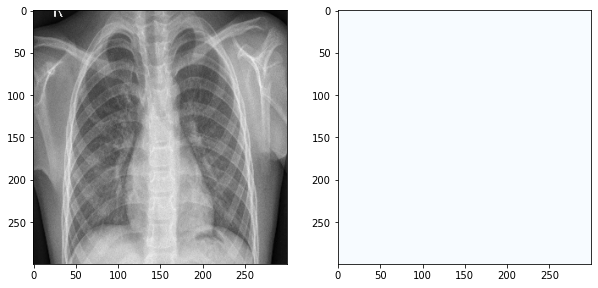

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)

plt.subplot(121),plt.imshow(normal_image, cmap='gray', vmin=0, vmax=255)
plt.subplot(122),plt.imshow(compute_saliency_map(normal_image_tf, model), cmap=plt.cm.Blues)

pred is: [6.567271e-24 1.000000e+00] and class_idxs_sorted[0] is 1


(<matplotlib.axes._subplots.AxesSubplot at 0x7f7fa50b5240>,
 <matplotlib.image.AxesImage at 0x7f7fa503d5f8>)

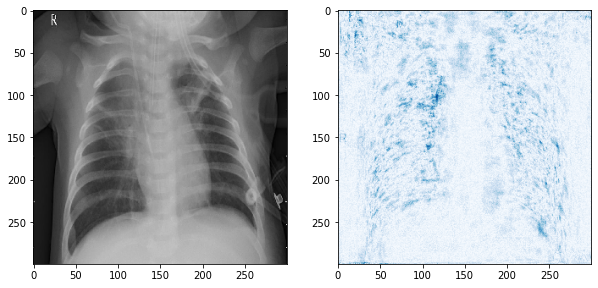

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)

plt.subplot(121),plt.imshow(pnemonia_image, cmap='gray', vmin=0, vmax=255)
plt.subplot(122),plt.imshow(compute_saliency_map(pnemonia_image_tf, model), cmap=plt.cm.Blues)

## Reference

- OpenCV tutorial on Image processing in Google Colab: https://github.com/xn2333/OpenCV
- https://www.kaggle.com/digvijayyadav/deep-learning-and-transfer-learning-on-covid-19
- Tutorial on Fourier Transform: http://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm
- Saliency map: https://usmanr149.github.io/urmlblog/cnn/2020/05/01/Salincy-Maps.html